# Data Preparation

## Import data

In [2]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

### Ubereats

In [3]:
url = "https://raw.githubusercontent.com/cedricly-git/BADS_Capstone_repo/main/Data/ubereats+time_related_vars.csv"

In [4]:
uber = pd.read_csv(url)

In [5]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Day                       728 non-null    object 
 1   trend_value               728 non-null    int64  
 2   weight                    728 non-null    float64
 3   total_ubereats            728 non-null    int64  
 4   estimated_daily_searches  728 non-null    int64  
 5   weekday                   728 non-null    object 
 6   is_weekend                728 non-null    int64  
 7   is_holiday                728 non-null    int64  
 8   month                     728 non-null    object 
 9   season                    728 non-null    object 
dtypes: float64(1), int64(5), object(4)
memory usage: 57.0+ KB


### Weather

In [6]:
# Define parameters
cities = {
    "Zurich": {"lat": 47.3769, "lon": 8.5417},
    "Geneva": {"lat": 46.2044, "lon": 6.1432},
    "Basel": {"lat": 47.5596, "lon": 7.5886}
}
start_date = "2023-11-13"
end_date = "2025-11-11"

weather_data = []

# Loop through cities
for city, coords in cities.items():
    url1 = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={coords['lat']}&longitude={coords['lon']}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=Europe/Zurich"
    )
    data = requests.get(url1).json()
    for i, date in enumerate(data['daily']['time']):
        weather_data.append({
            "Day": datetime.strptime(date, "%Y-%m-%d"),
            "City": city,
            "Temp_Max": data['daily']['temperature_2m_max'][i],
            "Temp_Min": data['daily']['temperature_2m_min'][i],
            "Precipitation": data['daily']['precipitation_sum'][i]
        })

# Convert to DataFrame
weather_df = pd.DataFrame(weather_data)


In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Day            2190 non-null   datetime64[ns]
 1   City           2190 non-null   object        
 2   Temp_Max       2190 non-null   float64       
 3   Temp_Min       2190 non-null   float64       
 4   Precipitation  2190 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 85.7+ KB


In [13]:
# Convert UberEats Day column to datetime
uber['Day'] = pd.to_datetime(uber['Day'])

# If you have a city column in UberEats, make sure it matches weather_df['City']
# For now, let's assume all UberEats data is for Zurich
uber['City'] = 'Zurich'

# Create average temperature column
weather_df['Temp_Avg'] = (weather_df['Temp_Max'] + weather_df['Temp_Min']) / 2

# Merge datasets
merged_df = pd.merge(uber, weather_df, on=["Day", "City"], how="left")

# Check the result
print(merged_df.head())
print(f"Merged dataset shape: {merged_df.shape}")

         Day  trend_value    weight  total_ubereats  estimated_daily_searches  \
0 2023-11-13           35  0.003880          236627                       918   
1 2023-11-14           52  0.005765          236676                      1364   
2 2023-11-15           74  0.008204          232238                      1905   
3 2023-11-16           44  0.004878          233488                      1139   
4 2023-11-17           53  0.005876          258156                      1517   

     weekday  is_weekend  is_holiday     month season    City  Temp_Max  \
0     Monday           0           0  November   Fall  Zurich      15.3   
1    Tuesday           0           0  November   Fall  Zurich      14.4   
2  Wednesday           0           0  November   Fall  Zurich      10.8   
3   Thursday           0           0  November   Fall  Zurich      11.1   
4     Friday           0           0  November   Fall  Zurich      10.7   

   Temp_Min  Precipitation  Temp_Avg  
0       9.6            

## Feature Engineering

In [14]:
# Feature Engineering

# Convert "Day" to datetime format
merged_df["Day"] = pd.to_datetime(merged_df["Day"])

# Extract day of week and month number
merged_df["dayofweek"] = merged_df["Day"].dt.weekday    
merged_df["month_num"] = merged_df["Day"].dt.month

# Encode categorical variables
merged_df = pd.get_dummies(merged_df, columns=["season", "month"], drop_first=True)

In [15]:
# Define target and features
y = merged_df["total_ubereats"]

X = merged_df[[
    "is_weekend", 
    "is_holiday",
    "dayofweek",
    "Temp_Max",
    "Precipitation",
]]

## Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

coef = pd.DataFrame({
    "feature": X.columns,
    "coef": model.coef_
})

print(coef)


         feature          coef
0     is_weekend    429.077892
1     is_holiday -27361.902453
2      dayofweek    440.636699
3       Temp_Max   1087.662629
4  Precipitation  -2225.328800


## Graph (Histogram)

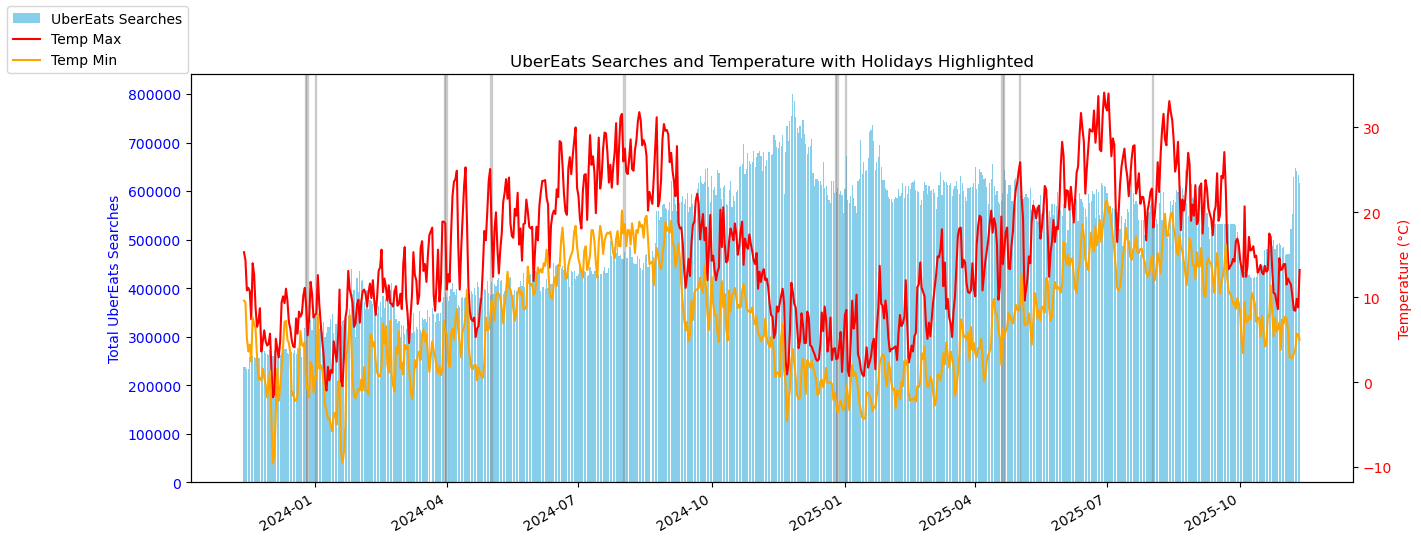

In [12]:
# Assume merged_df has columns: Day, total_ubereats, Temp_Max, Temp_Min, is_holiday

fig, ax1 = plt.subplots(figsize=(15,6))

# Plot UberEats searches as bars
ax1.bar(merged_df['Day'], merged_df['total_ubereats'], color='skyblue', label='UberEats Searches')
ax1.set_ylabel('Total UberEats Searches', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot temperature on a second y-axis
ax2 = ax1.twinx()
ax2.plot(merged_df['Day'], merged_df['Temp_Max'], color='red', label='Temp Max')
ax2.plot(merged_df['Day'], merged_df['Temp_Min'], color='orange', label='Temp Min')
ax2.set_ylabel('Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Highlight holidays
for i, row in merged_df.iterrows():
    if row['is_holiday'] == 1:
        ax1.axvspan(row['Day'], row['Day'] + pd.Timedelta(days=1), color='grey', alpha=0.3)

# Improve layout
fig.autofmt_xdate()
fig.legend(loc='upper left')
plt.title('UberEats Searches and Temperature with Holidays Highlighted')
plt.show()
